## DeepVoice1

### Abstract

Deep Voice ，一个完全由深度神经网络构建的生产质量的文本到语音系统，为真正的端到端神经语音合成奠定了基础。

该系统包括五个主要的模块：segmentation model for locating phoneme boundaries(定位音素边界的分割模型)、a grapheme-to-phoneme conversional model(字素-音素转换模型)、a phoneme duration prediction model(音素时长预测模型)、a fundamental frequency prediction model(基频预测模型)和 an audio synthesis model(音频合成模型).

在音素分割模型中，论文提出了一种基于深度神经网络的音素边界检测方法，使用了connectionist temporal classification(CTC) loss。对于音频合成模型，论文实现了一个WaveNet的变体 ，它需要的参数更少，比原来的训练更快。

通过为每个组件使用神经网络，论文提出的系统比传统的文本到语音系统更简单、更灵活；在传统的系统中，每个组件都需要费力的特征工程和广泛的领域专业知识。最后，论文提出的系统可以比实时更快地执行推理，并描述了 CPU 和 GPU 上优化的 WaveNet 推理内核，比现有的实现可达到400倍的速度

### 1.Introduction

从文本中合成人工语音，通常被称为文本到语音（TTS），在许多应用中是一个重要的组成部分。例如支持语音的设备、导航系统，以及视障人士的可访问性。从根本上说，它允许人机交互无需视觉界面。现代 TTS 系统基于复杂的多阶段处理管道，每个都可能依赖手动提取特征和启发式(hand-engineered features and heuristics)。由于这种复杂性，开发新的 TTS系统可能是非常费力和困难的。

Deep Voice 的灵感来自传统的文字转语音管道并采用相同的结构，同时用神经网络代替所有的组件并使用更简单的特征：首先我们将文本转换为音素，然后使用音频合成模型将文字特征转为语音。与以前的工作不同（使用手动设计特征，如光谱包络， 光谱参数、非周期参数等），系统中唯一的特征是带有重音注释的音素，音素持续时间和基频（$F_0$）。这种特性的选择使系统更容易适用于新的数据集、声音和领域，而不需要任何手动数据注释或额外的特性工程。我们通过在新数据上重新训练整个管道产生相对高质量的语音而无需更改任何参数的方式证明了我们的观点，新数据仅包含音频和未对齐的文本转录(textual transcription)。 在传统的 TTS 系统中，这种调整需要几天到几周的时间，而 Deep Voice 只需要几个小时的人工工作和模型训练时间。

实时推理是生产质量TTS系统的要求；如果没有它，系统就不能用于大多数TTS的应用。先前的工作已经证明，WaveNet 就可以产生接近人类水平的语音。 然而，由于 WaveNet 模型的高频、自回归特性，WaveNet有一个令人生畏的(daunting)计算问题，迄今为止还不知道这种模型是否可以用于生产系统。我们以肯定的方式回答这个问题并且展示了高效、比实时更快的 WaveNet 推理内核，它产生高质量的 16 kHz 音频，并且实现了对之前的 WaveNet 推理的 400 倍的加速。

### 2.Related Work

之前的研究使用神经网络替代多个TTS系统组件，包括字素-音素转换模型，音素持续时间预测模型，基础频率预测模型和音频合成模型。然而，与 Deep Voice 不同的是，这些系统都不能解决 TTS 的全部问题，许多系统使用专门为其领域开发的 hand-engineered features.

最近，在参数音频合成方面有很多工作，特别是 WaveNet 、 SampleRNN 和 Char2Wav 。 WaveNet 可以用于条件和无条件音频产生，但 SampleRNN 只用于无条件音频产生。 Char2Wav 用一个基于注意的音素持续时间模型和等效的 $F_0$ 预测模型扩展了 SampleRNN ，有效地为基于 SampleRNN 的声码器提供了本地条件信息。

Deep Voice 在几个关键方面与这些系统不同，显著地增加了问题的范围。

首先， Deep Voice 是完全独立的；训练新的 Deep Voice 系统不需要预先存在的 TTS 系统，可以使用短音频剪辑(short audio clips)数据集和相应的文本文本从头开始。相反reproducing either of the aforementioned systems requires access and understanding of a pre-existing TTS system,，因为它们在训练或推理时使用来自另一个 TTS 系统的特征。

其次， Deep Voice 最大限度地减少了人工工程功能的使用；它使用独热编码字符进行字素到音素的转换、对音素和重音进行独热编码处理，音素持续时间（毫秒）和标准化对数基频（可以使用任何 F0 估计算法从波形计算）。所有这些都可以用最小的力气很容易地从音频和文本中获得。相比之下，以前的工作使用了更复杂的特性工程，如果没有预先存在的 TTS 系统，就不可能有效地复现系统。

WaveNet 从 TTS 系统使用多个特征如一个单词音节的数量，在短语中音节的位置，当前帧的音素，语音频谱的动态特征如 spectral and excitation parameter, 以及他们的时间导数。        
Char2Wav 依赖 WORLD TTS 系统的声码器特征来预训练他们的对齐模块，其中包括 F0 、光谱包络和非周期参数。

最后，我们集中于创建一个可用于生产的系统，这要求我们的模型实时运行以进行推理。 Deep Voice 可以在几分之一秒内合成音频，并提供了合成速度和音频质量之间的可调平衡。 相比之下，以前的 WaveNet 需要几分钟的运行时间才能合成一秒钟的音频。对于 SampleRNN 我们不知道相似的基准。 SampleRNN 原始出版物中描述的 3 层架构在推理过程中需要的计算量大约是我们最大的 WaveNet 模型的 4-5 倍，所以实时运行模型可能会很有挑战性。

### 3.TTS System Components

TTS系统由五个主要的构建模块组成：

- **The grapheme-to-phoneme model**：将书面文本(英语字符)转换为音素(使用像ARPABET这样的音素字母表编码)。
       
- **The segmentation model**：对语音数据集中的音素边界进行定位。给定一个音频文件和音频的一个音素逐音素转录，分割模型确定每个音素在音频中的起始和结束位置。
       
- **The phoneme duration model**：预测音素序列(一句话)中每个音素的时间持续时间。
       
- **The fundamental frequency model**：预测一个音素是否被发声；如果是，该模型预测整个音素持续时间的基频（F0）。
       
- **The audio synthesis model**：将字素到音素、音素持续时间和基频预测模型的输出组合，并以与所需文本相对应的高采样率合成音频。

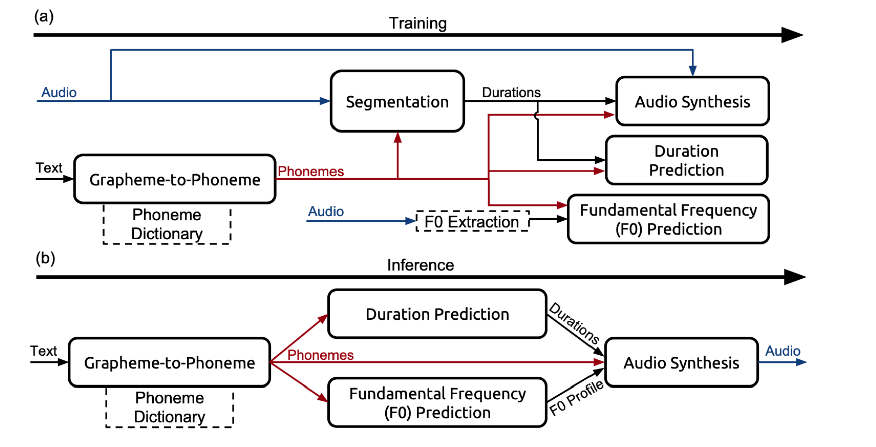

Figure 1. System diagram depicting (a) training procedure and (b) inference procedure, with inputs on the left and outputs on the right. 
In our system, the duration prediction model and the F0 prediction model are performed by a single neural network trained with a joint 
loss. The grapheme-to-phoneme model is used as a fallback for words that are not present in a phoneme dictionary, such as CMUDict. 
Dotted lines denote non-learned components.

在推理过程中：通过 grapheme-to-phoneme 或音素字典输入文本来生成音素. 接下来，将音素作为音素持续时间模型和 F0 预测模型的输入提供，以便为每个音素分配持续时间并生成 F0 轮廓;最后，将音素、音素时长和 F0 作为语音合成模型的局部条件输入特征，生成最终的语音。

与其他模型不同的是，在推理过程中不使用分割模型；相反，它用于用音素边界标注训练语音数据；音素边界暗示着音素持续时间，可以用来训练音素持续时间模型；在语音合成模型中，使用带有标注的音素、音素持续时间和基频的音频进行训练。

接下来我们对每个模块进行详细描述。

#### 3.1 Grapheme-to-Phoneme Model

**Abstract**

The grapheme-to-phoneme converter converts from written text (e.g English characters) to phonemes (encoded using a phonemic alphabet such as ARPABET).

**Architecture**

The Grapheme-to-phoneme converter is an encoder-decoder:

- Encoder: multi-layer, bidirectional encoder, with a gated recurrent unit (GRU) nonlinearity.       
- Decoder: identical to the encoder but unidirectional.       

It takes written text as input.

**Setup**

- Initialization: every decoder layer is initialized to the final hidden state of the corresponding encoder forward layer.
- Training: the architecture is trained with teacher forcing.        
- Decoding: performed using beam search.       

**Hyperparameters**

- Encoder: 3 bidirectional layers with 1024 units each.        
- Decoder: 3 unidirectional layers of the same size as the encoder.       
- Beam Search: width of 5 candidates.         
- Dropout: 0.95 rate after each recurrent layer.